Define global variables
===

In [77]:
from utils import *
import transformations.transformations as TF
from scipy.spatial.transform import Rotation as R

file_path = os.path.join(os.getcwd(),"..","data")
save_file_path = os.path.join(file_path,"scraft.csv")

# Geometry parameters
r_earth = 6378; # radius of earth in kilometers
r_moon = 1737; # radius of moon in kilometers
distance_earth_moon = 384400; # in kilometers
rot_speed_earth = 0 # 2*pi/(24*3600); # rad/s
rot_speed_moon = 0 # 2 * pi / (27.32 * 24 * 3600); # rad/s
inclination = radians(5.14)
phi_synodic_earth = radians(28.58); # deg 
phi_synodic_moon = radians(6.68); # deg
G = 6.67430e-20; # Gravity constant in km^3*kg^-1*h^-2
g_zero_point = np.array([346019.66, 0, 0])

# # Transformation of earth, moon w.r.t synodic
R_synodic_earth_0 = R.from_euler('y', phi_synodic_earth, degrees=False).as_matrix()
ang_vel_earth = np.dot(R_synodic_earth_0, np.array([0, 0, 1]))*rot_speed_earth
R_synodic_moon_0 = R.from_euler('y', phi_synodic_moon, degrees=False).as_matrix()
# ang_vel_moon = np.dot(R_synodic_moon_0, np.array([0, 0, 1]))*rot_speed_moon
ang_vel_moon = np.zeros(3)

# Physical parameters
mass_earth = 5.97219e24  # kg
mass_moon = 7.34767e22  # kg
mass_sc = 49735  # kg (initial mass of spacecraft)
mass_sc_final = 4000  # kg (final mass of spacecraft after fuel consumption)

# Thrust parameters
Ve = 12  # Exhaust velocity in km/s
m_dot = 4000  # Mass flow rate in kg/s

# State variables
phi_earth_space = np.deg2rad(60)
theta_earth_space = np.deg2rad(100)
time_stamp = [0]
theta_synodic_space = np.deg2rad(139.0933)
fire_angle = np.deg2rad(42.2394)

X_sc, V_sc, A_sc, thrust_unit = set_initial_new(
    theta = theta_synodic_space,
    alpha = fire_angle,
    r_earth=r_earth
)

# breakpoint()

# Simulation parameters
time_escape_eath = 0.0 
time_to_zero_gra = 0.0
time_land_moon = 0.0
delta_T = 1; # simulation time step (hour)

# Class Space 
Earth = Planet(
    mass=mass_earth,
    radius=r_earth,
    ang_vel=ang_vel_earth,
    theta=0.0,
    phi=phi_synodic_earth,
    distance_synodic=0,
    incline_synodic=0
)

Moon = Planet(
    mass=mass_moon,
    radius=r_moon,
    ang_vel=ang_vel_moon,
    theta=0.0,
    phi=phi_synodic_moon,
    distance_synodic=distance_earth_moon,
    incline_synodic=inclination
)

space_craft = SpaceCraft(
    save_file=save_file_path,
    mass=mass_sc,
    mass_final=mass_sc_final,
    Ve = Ve,
    m_dot=m_dot,
    X_init=X_sc,
    V_init=np.zeros(3),
    A_init=np.zeros(3),
    thrust_unit=thrust_unit
)

space_craft.reset(save_file=save_file_path, m=mass_sc, x=X_sc, v=V_sc, a=A_sc)

time_step = 1
steps = int(1*3600)

# Burning process
time_phase1 = 6

In [78]:
Moon.x

array([385952.00457365,      0.        ,      0.        ])

Find Optimal Firing Angle
====

In [7]:
#### Find fire angle alpha ######
alpha_ = []
h_max_ = []
v_min_ = []

for alpha in range(10,90):
    # Reset stage of spacecraft
    X_sc, V_sc, A_sc, thrust_unit = set_initial_new(
        theta = theta_synodic_space,
        alpha = radians(alpha),
        r_earth=r_earth
    )
    space_craft.reset(save_file=save_file_path, m=mass_sc, x=X_sc, v=V_sc, a=A_sc)
    
    # Simulation
    for i in range(0, steps, 1):
        if i < time_phase1:
            thrust_unit_input = thrust_unit
        else:
            thrust_unit_input = None
        space_craft.step_update(G=G, 
                                earth=Earth, 
                                moon=Moon, 
                                thrust_unit=thrust_unit_input, 
                                m_dot=4000,
                                Ve=12,
                                time_step=time_step)
    
    # Find the h max, v min
    file = pandas.read_csv(save_file_path)
    position = np.array(file['Position'].apply(eval).tolist())
    velocity = np.array(file['Velocity'].apply(eval).tolist())
    x = position[:,0]
    y = position[:,1]
    z = position[:,2] 
    h = np.sqrt(np.power(x,2) + np.power(y,2) + np.power(z,2))
    h_max = np.max(h)
    index = np.argmax(h)
    v = velocity[index,:]
    v_min = np.linalg.norm(v)
    
    # Save value
    alpha_.append(alpha)
    h_max_.append(float(h_max))
    v_min_.append(float(v_min))

59.790416481043586 6812.047257449109
-0.08412445223069723 7.361911794873688


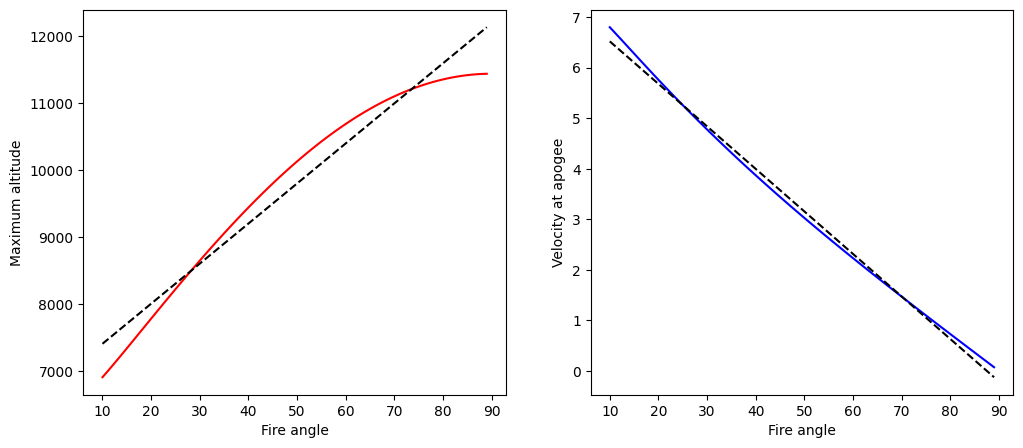

In [8]:
#### Correlation between fire angle, max altitude, v
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(np.array(alpha_), np.array(h_max_), 'r')
ax[0].set_xlabel('Fire angle')
ax[0].set_ylabel('Maximum altitude')

ax[1].plot(np.array(alpha_), np.array(v_min_), 'b')
ax[1].set_xlabel('Fire angle')
ax[1].set_ylabel('Velocity at apogee')

# ax[1,0].plot(np.array(v_min_), np.array(h_max_), 'c')
# ax[1,0].set_xlabel('Maximum altitude')
# ax[1,0].set_ylabel('Velocity at apogee')

# ax[1,1].plot(np.array(alpha_), np.multiply(np.array(h_max_), np.array(v_min_)), 'g')
# ax[1,1].set_xlabel('Fire angle')
# ax[1,1].set_ylabel('Angular momentum at apogee')

# Fiting angle, h
from scipy.stats import linregress
slope1, intercept1, r_value, p_value, std_err = linregress(alpha_, h_max_)
print(slope1, intercept1)
y_fit = slope1 * np.array(alpha_) + intercept1
ax[0].plot(np.array(alpha_), y_fit, 'k--')

# Fiting angle, v
slope2, intercept2, r_value, p_value, std_err = linregress(alpha_, v_min_)
print(slope2, intercept2)
y_fit = slope2 * np.array(alpha_) + intercept2
ax[1].plot(np.array(alpha_), y_fit, 'k--')


In [28]:
######## Find optimal fire angle ############### 
import scipy.optimize as opt

# Given constants
c = 123702

# Define the function v to be minimized
def v_function(alpha):
    return c / (slope1 * alpha + intercept1) - (slope2 * alpha + intercept2)

# Use minimize_scalar to find the value of alpha that minimizes v
result = opt.minimize_scalar(v_function, bounds=(20, 90), method='bounded')

# Extract the optimal alpha
alpha_opt = result.x # 42.2394 degree
v_min = result.fun

print(f"The value of alpha that minimizes delta_v is: alpha = {alpha_opt:.4f}")
print(f"The minimum value of delta_v is: {v_min:.4f}")

The value of alpha that minimizes delta_v is: alpha = 42.8915
The minimum value of delta_v is: 9.4390


Find Optimal Launching Position
===

In [31]:
###### Calculate real h_max and vel_min
X_sc, V_sc, A_sc, thrust_unit = set_initial_new(
    theta = radians(0),
    alpha = radians(alpha_opt),
    r_earth=r_earth
)
space_craft.reset(save_file=save_file_path, m=mass_sc, x=X_sc, v=V_sc, a=A_sc)

# Simulation
steps = int(2*3600)
for i in range(0, steps, 1):
    if i < time_phase1:
        thrust_unit_input = thrust_unit
    else:
        thrust_unit_input = None
    space_craft.step_update(G=G, 
                            earth=Earth, 
                            moon=Moon, 
                            thrust_unit=thrust_unit_input, 
                            m_dot=4000,
                            Ve=12,
                            time_step=time_step)

# Find the h max, v min
file = pandas.read_csv(save_file_path)
position = np.array(file['Position'].apply(eval).tolist())
velocity = np.array(file['Velocity'].apply(eval).tolist())
x = position[:,0]
y = position[:,1]
z = position[:,2] 
h = np.sqrt(np.power(x,2) + np.power(y,2) + np.power(z,2))
h_max = np.max(h)
index = np.argmax(h)
v = velocity[index,:]
v_min = np.linalg.norm(v)

# Find beta 
beta = pi-atan2(y[index],x[index])
theta_synodic_space_opt = degrees(0 + beta) # 139.0933
print(f"Maximum altitude: {h_max:.2f}")
print(f"Velocity at apogee: {v_min:.2f}")
print(f"The optimal launching position: {theta_synodic_space_opt:.4f}")
print(f"Time to obtain apogee: {index:d}")

Maximum altitude: 9654.10
Velocity at apogee: 3.62
The optimal launching position: 139.5922
Time to obtain apogee: 1435


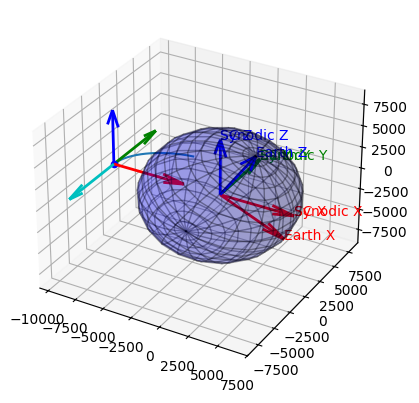

In [86]:
####### Verify Value ########

# Reset system with optimal values
phase1_file = os.path.join(file_path,"scraft_1.csv")

X_sc, V_sc, A_sc, thrust_unit = set_initial_new(
    theta = np.deg2rad(139.0933),
    alpha = np.deg2rad(42.2394),
    r_earth=r_earth
)
space_craft.reset(save_file=phase1_file, m=mass_sc, x=X_sc, v=V_sc, a=A_sc)

# Simulation 
for i in range(0, 1428, 1):
    if i < time_phase1:
        thrust_unit_input = thrust_unit 
    else:
        thrust_unit_input = None

    space_craft.step_update(G=G, earth=Earth, moon=Moon, thrust_unit=thrust_unit_input, time_step=time_step)

# Visualize
visualize_system(
    spacecraft_state_file=phase1_file,
    spacecraft=space_craft,
    earth=Earth,
    moon=Moon,
    g_zero_point=g_zero_point,
    show_earth=True,
    show_moon=False,
    scale_axis=1
)

Phase2: Enter Earth Orbit 
===

In [87]:
# Create a new file
space_craft.reset()
file = pandas.read_csv(phase1_file)
position = np.array(file['Position'].apply(eval).tolist())
velocity = np.array(file['Velocity'].apply(eval).tolist())
mass = np.array(file['Mass'])
acceleration = np.array(file['Acceleration'].apply(eval).tolist())

phase2_file = os.path.join(file_path, "scraft_2.csv")
space_craft.reset(save_file=phase2_file, m=mass[-1], x=position[-1], v=velocity[-1], a=acceleration[1])


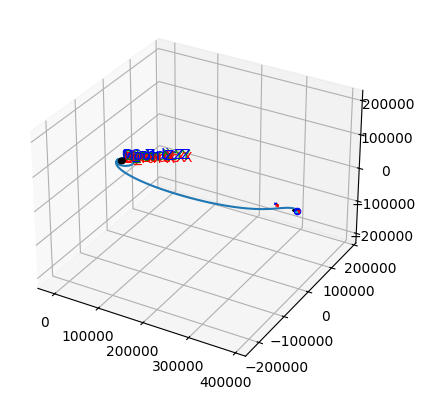

In [88]:
count = 0
steps = int(70*24*3600)
previous = False
for i in range(0, steps, 10):
    # Break at the back of Moon
    if space_craft.x[0] > Moon.x[0] and abs(space_craft.x[1]) < 50:
        break

    if space_craft.x[0] < 0 and abs(space_craft.x[1]) < 50:
        if not previous: 
            count += 1
            if count == 1:
                thrust_unit_input = np.array([0,-1,0])
                space_craft.step_update(G=G, earth=Earth, moon=Moon, thrust_unit=thrust_unit_input, time_step=1)
                space_craft.step_update(G=G, earth=Earth, moon=Moon, thrust_unit=thrust_unit_input, time_step=1)
                # space_craft.step_update(G=G, earth=Earth, moon=Moon, thrust_unit=thrust_unit_input, time_step=1)
                thrust_unit_input = None
            elif count == 2:
                thrust_unit_input = np.array([0,-0.11,0])
                space_craft.step_update(G=G, earth=Earth, moon=Moon, thrust_unit=thrust_unit_input, m_dot=4000, time_step=1)
                space_craft.step_update(G=G, earth=Earth, moon=Moon, thrust_unit=thrust_unit_input, m_dot=4000, time_step=1)
                space_craft.step_update(G=G, earth=Earth, moon=Moon, thrust_unit=thrust_unit_input, m_dot=4000, time_step=1)
                thrust_unit_input = None
            else:
                thrust_unit_input = None
            previous = True
        else: 
            thrust_unit_input = None
    else:
        thrust_unit_input = None
        previous = False

    # Update state
    space_craft.step_update(G=G, earth=Earth, moon=Moon, thrust_unit=thrust_unit_input, time_step=time_step)

visualize_system(
    spacecraft_state_file=phase2_file,
    spacecraft=space_craft,
    earth=Earth,
    moon=Moon,
    g_zero_point=g_zero_point,
    show_earth=True,
    show_moon=True,
    scale_axis=1
)

Phase3: Comeback Earth
===

In [90]:
# Create a new file
file = pandas.read_csv(phase2_file)
position = np.array(file['Position'].apply(eval).tolist())
velocity = np.array(file['Velocity'].apply(eval).tolist())
mass = np.array(file['Mass'])
acceleration = np.array(file['Acceleration'].apply(eval).tolist())

phase3_file = os.path.join(file_path, "scraft_3.csv")
space_craft.reset(save_file=phase3_file, m=mass[-1], x=position[-1], v=velocity[-1], a=acceleration[1])

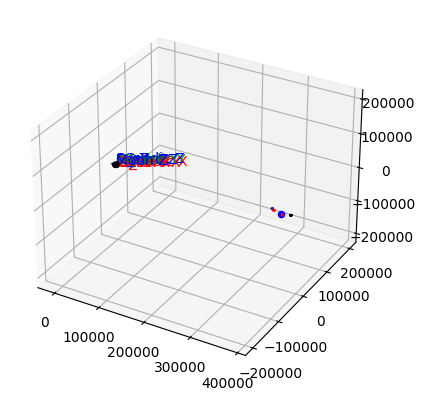

In [91]:
steps = int(5*24*3600)
for i in range(0, steps, 10):
    if i==0:
        thrust_unit_input = np.array([-1,0,0])
        space_craft.step_update(G=G, earth=Earth, moon=Moon, thrust_unit=thrust_unit_input, Ve=2.19, m_dot=1000, time_step=1)   
        thrust_unit_input = None
    else:
        thrust_unit_input = None

    # Update state
    space_craft.step_update(G=G, earth=Earth, moon=Moon, thrust_unit=thrust_unit_input, time_step=time_step)

visualize_system(
    spacecraft_state_file=save_file_path,
    spacecraft=space_craft,
    earth=Earth,
    moon=Moon,
    g_zero_point=g_zero_point,
    show_earth=True,
    show_moon=True,
    scale_axis=1
)  

In [131]:
distance_min_opt = distance_earth_moon
m_dot_opt = 1000

for m_dot in range(1000,3000,100):
    
    # Reset
    file = pandas.read_csv(save_file_path)
    position = np.array(file['Position'].apply(eval).tolist())
    velocity = np.array(file['Velocity'].apply(eval).tolist())
    mass = np.array(file['Mass'])
    acceleration = np.array(file['Acceleration'].apply(eval).tolist())

    phase2_path = os.path.join(file_path, "scraft_2.csv")
    space_craft.reset(save_file=phase2_path, m=mass[-1], x=position[-1], v=velocity[-1], a=acceleration[-1])

    # Simulation
    count = 0
    steps = int(50*24*3600)
    previous = False
    index = 0
    for i in range(0, steps, 10):
        if space_craft.x[0] < 0 and abs(space_craft.x[1]) < 100:
            if not previous: 
                count += 1
                if count == 1:
                    thrust_unit_input = np.array([0,-1,0])
                    space_craft.step_update(G=G, 
                                            earth=Earth, 
                                            moon=Moon, 
                                            thrust_unit=thrust_unit_input, 
                                            Ve=12,
                                            m_dot=4000, 
                                            time_step=2)                
                    thrust_unit_input = None
                elif count == 2:
                    thrust_unit_input = np.array([0,-1,0])
                    space_craft.step_update(G=G, 
                                            earth=Earth, 
                                            moon=Moon, 
                                            thrust_unit=thrust_unit_input, 
                                            Ve=4.5,
                                            m_dot=m_dot, 
                                            time_step=3)
                    thrust_unit_input = None
                else:
                    thrust_unit_input = None
                previous = True
            else: 
                thrust_unit_input = None
        else:
            thrust_unit_input = None
            previous = False

        space_craft.step_update(G=G, earth=Earth, moon=Moon, thrust_unit=thrust_unit_input, time_step=time_step)
        index += 1
    
    # Check value
    file = pandas.read_csv(phase2_path)
    position = np.array(file['Position'].apply(eval).tolist())
    distance = position-g_zero_point
    distance_min = np.min(np.linalg.norm(distance, axis=1))

    # Check min
    if distance_min <= distance_min_opt:
        distance_min_opt = distance_min
        m_dot_opt = m_dot

print(m_dot_opt)
# Visualize
# visualize_system(
#     ax,
#     spacecraft_state_file=phase2_path,
#     spacecraft=space_craft,
#     earth=Earth,
#     moon=Moon,
#     g_zero_point=g_zero_point,
#     show_earth=True,
#     show_moon=True,
#     scale_axis=1
# )


1600


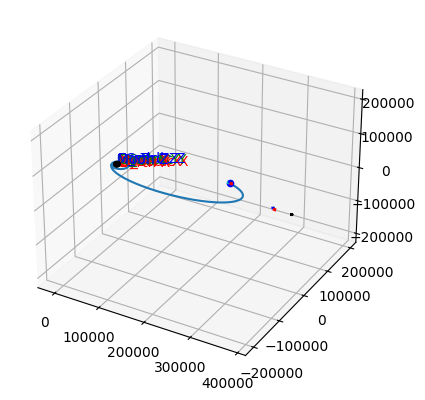

In [17]:
############### STAGE 2 ################
count = 0
steps = int(50*24*3600)
previous = False
index = 0
space_craft.reset(save_file=phase2_path, m=mass[-1], x=position[-1], v=velocity[-1], a=acceleration[-1])
for i in range(0, steps, 10):
    if space_craft.x[0] < 0 and abs(space_craft.x[1]) < 100:
        if not previous: 
            count += 1
            if count == 1:
                thrust_unit_input = np.array([0,-1,0])
                space_craft.step_update(G=G, earth=Earth, moon=Moon, thrust_unit=thrust_unit_input, time_step=1)
                space_craft.step_update(G=G, earth=Earth, moon=Moon, thrust_unit=thrust_unit_input, time_step=1)
                # space_craft.step_update(G=G, earth=Earth, moon=Moon, thrust_unit=thrust_unit_input, time_step=1)
                thrust_unit_input = None
            elif count == 2:
                thrust_unit_input = np.array([0,-0.11,0])
                space_craft.step_update(G=G, earth=Earth, moon=Moon, thrust_unit=thrust_unit_input, m_dot=4000, time_step=1)
                space_craft.step_update(G=G, earth=Earth, moon=Moon, thrust_unit=thrust_unit_input, m_dot=4000, time_step=1)
                space_craft.step_update(G=G, earth=Earth, moon=Moon, thrust_unit=thrust_unit_input, m_dot=4000, time_step=1)
                thrust_unit_input = None
            else:
                thrust_unit_input = None
            previous = True
        else: 
            thrust_unit_input = None
    else:
        thrust_unit_input = None
        previous = False

    space_craft.step_update(G=G, earth=Earth, moon=Moon, thrust_unit=thrust_unit_input, time_step=time_step)
    index += 1

visualize_system(
    spacecraft_state_file=phase2_path,
    spacecraft=space_craft,
    earth=Earth,
    moon=Moon,
    g_zero_point=g_zero_point,
    show_earth=True,
    show_moon=True,
    scale_axis=1
)